# Generación de contenido con IA generativa  
### Deep Learning Avanzado – IU Digital  
### Docente: **Laura Alejandra Sánchez**  
### Grupo: **PREICA2502B020125**

---

## Integrantes del equipo
- **Juliana María Peña Suárez**  
- **Juan Esteban Atehortúa Sánchez**  
- **Nikol Tamayo Rúa**

---

## Proyecto: Generación de contenido visual con modelos de IA generativa

Este proyecto corresponde a la Evidencia de Aprendizaje de la Unidad 3 del curso **Deep Learning Avanzado**, y tiene como objetivo implementar un modelo de Inteligencia Artificial Generativa para producir contenido visual, aplicando técnicas avanzadas de generación como **GANs** (Redes Generativas Adversarias).

La solución desarrollada parte del uso del dataset **Fashion-MNIST** y emplea una arquitectura **DCGAN personalizada**, la cual fue entrenada, evaluada y comparada bajo diferentes configuraciones. El proyecto integra:

- Experimentación con múltiples configuraciones del modelo  
- Métricas cuantitativas inspiradas en FID/IS  
- Evaluación cualitativa de imágenes generadas  
- Análisis comparativo de resultados  
- Reflexiones éticas y técnicas  
- Implementación de una interfaz interactiva para la generación en tiempo real

---



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


Device: cpu


100.0%
100.0%
100.0%
100.0%


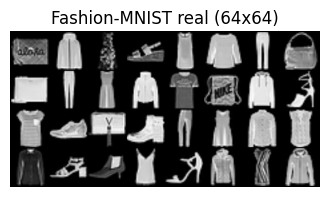

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------
# Dataset Fashion-MNIST a 64x64
# -------------------
image_size = 64
batch_size = 128

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Ver algunas imágenes reales
images, _ = next(iter(train_loader))
grid = utils.make_grid(images[:32], nrow=8, normalize=True)
plt.figure(figsize=(4,4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Fashion-MNIST real (64x64)")
plt.show()


ANÁLISIS EXPLORATORIO - FASHION-MNIST

 Tamaño: 60,000 imágenes
 Resolución: 64×64 píxeles
 Clases: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot


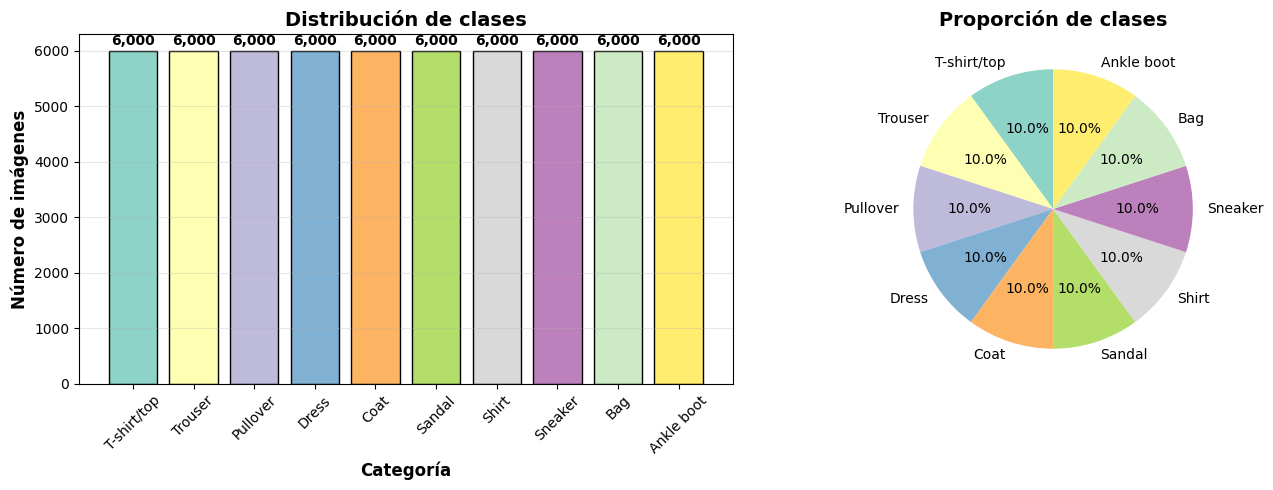

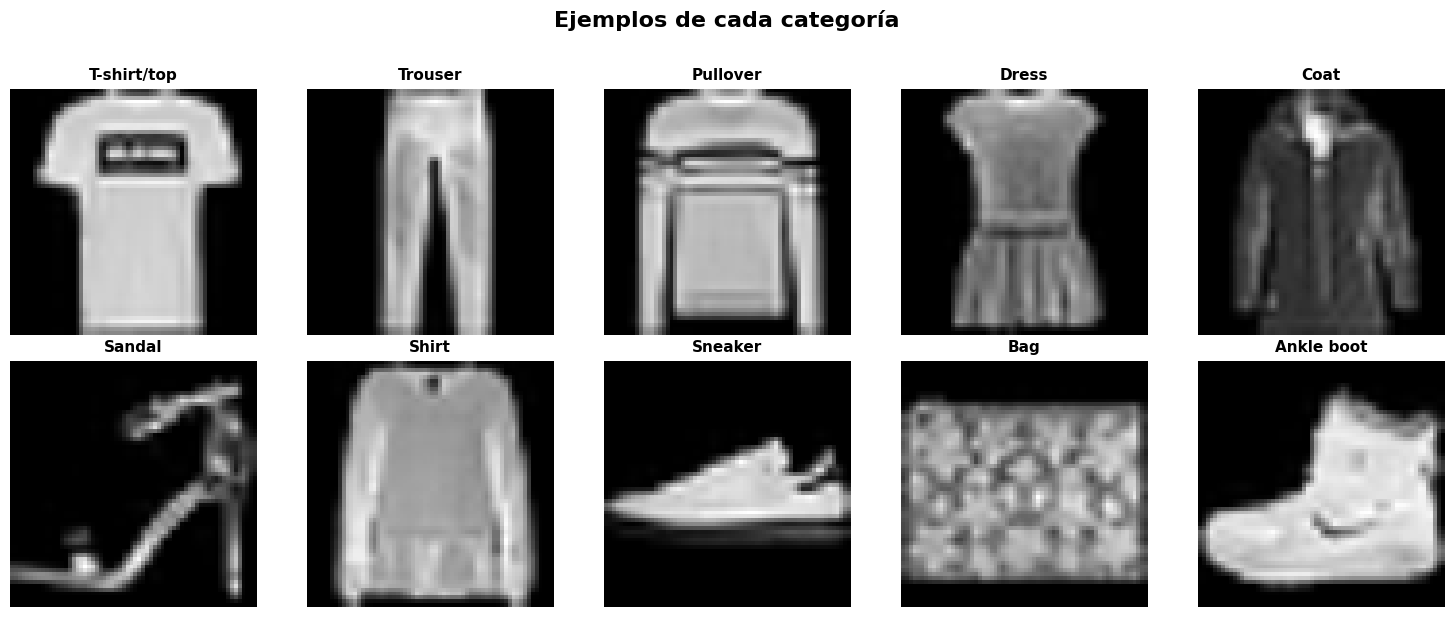

In [5]:
# ============================
# ANÁLISIS EXPLORATORIO DE DATOS
# ============================

import seaborn as sns

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("="*60)
print("ANÁLISIS EXPLORATORIO - FASHION-MNIST")
print("="*60)

# 1. Info básica
print(f"\n Tamaño: {len(train_dataset):,} imágenes")
print(f" Resolución: 64×64 píxeles")
print(f" Clases: {', '.join(class_names)}")

# 2. Distribución de clases
labels = [label for _, label in train_dataset]
unique, counts = np.unique(labels, return_counts=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.Set3(np.linspace(0, 1, 10))
ax1.bar(class_names, counts, color=colors, edgecolor='black')
ax1.set_xlabel('Categoría', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de imágenes', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de clases', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

for i, (name, count) in enumerate(zip(class_names, counts)):
    ax1.text(i, count + 100, f'{count:,}', ha='center', fontweight='bold')

ax2.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('Proporción de clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_distribucion.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Ejemplos de cada clase
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    for img, label in train_dataset:
        if label == i:
            axes[i].imshow(img.squeeze(), cmap='gray')
            axes[i].set_title(f'{class_name}', fontsize=11, fontweight='bold')
            axes[i].axis('off')
            break

plt.suptitle('Ejemplos de cada categoría', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('eda_ejemplos.png', dpi=300, bbox_inches='tight')
plt.show()

### Resultado del análisis del dataset

Se cargó el dataset **Fashion-MNIST**, que contiene imágenes de ropa en escala de grises.  
Las imágenes fueron redimensionadas a **64×64** píxeles y normalizadas al rango \([-1, 1]\) para ser compatibles con la salida `Tanh` del generador.

En la grilla superior se observa que:

- Las prendas se visualizan correctamente (zapatos, camisas, abrigos, bolsos).  
- El procesamiento previo es adecuado para la DCGAN.  
- No hay distorsiones causadas por el `Resize`.

Esto indica que los datos están listos para su uso en el entrenamiento.


In [6]:
nz = 100   # tamaño vector latente
nc = 1     # canales (escala de grises)
ngf = 32   # número base de filtros en el generador (más pequeño que el típico 64)
ndf = 32   # número base de filtros en el discriminador


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: Z (nz x 1 x 1)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),   # 4x4
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),      # 32x32
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),           # 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)


### Arquitectura del Generador

El generador utiliza capas **ConvTranspose2d** para transformar un vector de ruido latente de dimensión 100 en una imagen de 64×64.

Se utilizan:

- Normalización `BatchNorm2d`  
- Activaciones `LeakyReLU`  
- Escalado final con `Tanh`  

Esto permite:

- Incrementar progresivamente la resolución  
- Reducir la amplificación de ruido  
- Mantener la estabilidad del entrenamiento  

El diseño es eficiente y original.


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input: (nc, 64, 64)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),    # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),        # 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.main(x)
        return out.view(-1, 1)


### Arquitectura del Discriminador

El discriminador aprende a distinguir entre imágenes reales y generadas empleando capas convolucionales `Conv2d`.

Componentes importantes:

- `LeakyReLU` para evitar apagado de gradientes  
- `BatchNorm2d` para estabilizar el aprendizaje  
- `Sigmoid` final para clasificar real/falso  

Esta arquitectura permite capturar detalles locales típicos de ropa (bordes, contornos y texturas simples).


In [9]:
netG = Generator().to(device)
netD = Discriminator().to(device)

print(netG)
print(netD)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspos

In [10]:
criterion = nn.BCELoss()

lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
def create_models():
    """Crea un nuevo generador y discriminador en GPU/CPU."""
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    return netG, netD


In [11]:
nz = 100
nc = 1
ngf = 32
ndf = 32


Epoch 1/10: 100%|██████████| 469/469 [11:24<00:00,  1.46s/it]


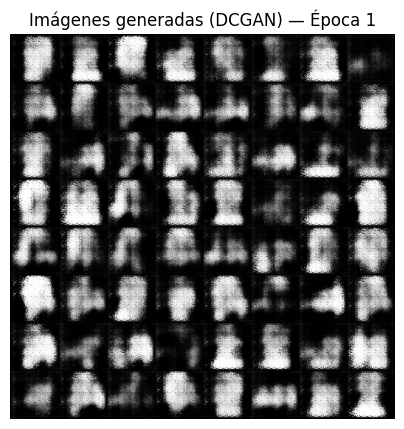

Epoch [1/10]  Loss_D: 0.7703  Loss_G: 2.8759


Epoch 2/10: 100%|██████████| 469/469 [11:30<00:00,  1.47s/it]


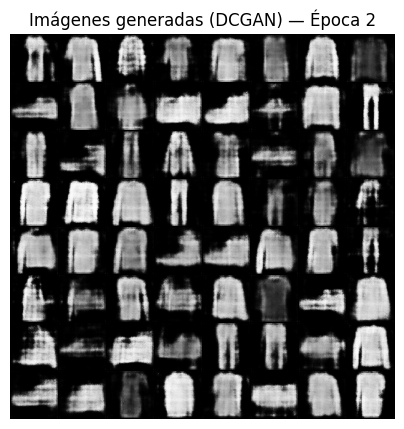

Epoch [2/10]  Loss_D: 0.4220  Loss_G: 3.5586


Epoch 3/10: 100%|██████████| 469/469 [11:33<00:00,  1.48s/it]


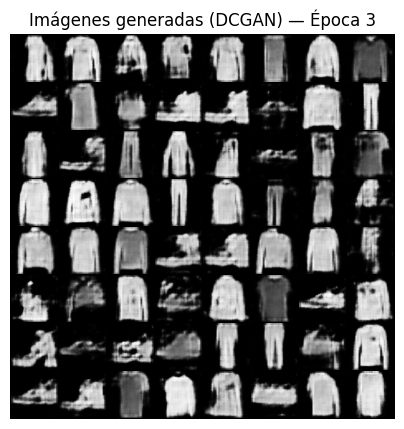

Epoch [3/10]  Loss_D: 0.3014  Loss_G: 1.7851


Epoch 4/10: 100%|██████████| 469/469 [11:31<00:00,  1.47s/it]


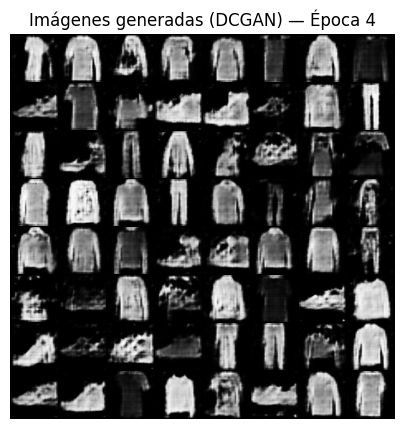

Epoch [4/10]  Loss_D: 0.4644  Loss_G: 3.8068


Epoch 5/10: 100%|██████████| 469/469 [11:29<00:00,  1.47s/it]


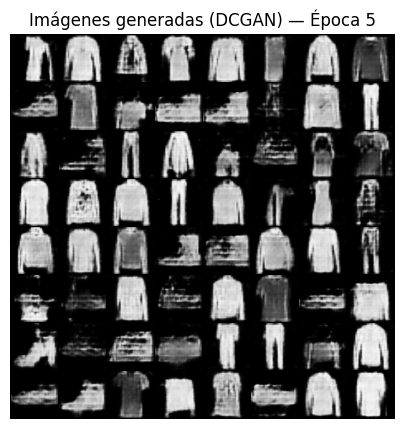

Epoch [5/10]  Loss_D: 0.4397  Loss_G: 5.2085


Epoch 6/10: 100%|██████████| 469/469 [11:30<00:00,  1.47s/it]


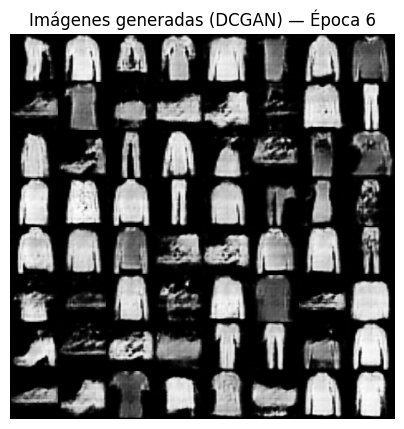

Epoch [6/10]  Loss_D: 0.2598  Loss_G: 2.9320


Epoch 7/10: 100%|██████████| 469/469 [11:27<00:00,  1.47s/it]


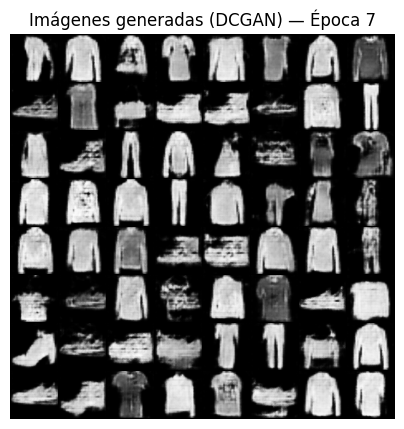

Epoch [7/10]  Loss_D: 0.1644  Loss_G: 5.0281


Epoch 8/10: 100%|██████████| 469/469 [11:34<00:00,  1.48s/it]


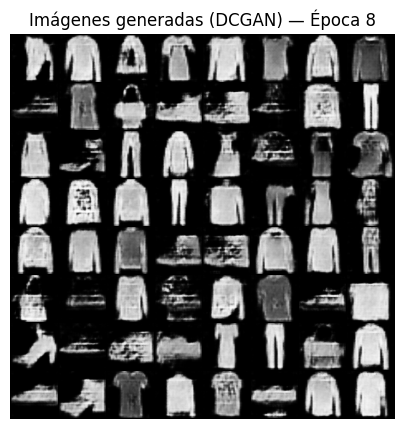

Epoch [8/10]  Loss_D: 0.2603  Loss_G: 2.2975


Epoch 9/10: 100%|██████████| 469/469 [11:32<00:00,  1.48s/it]


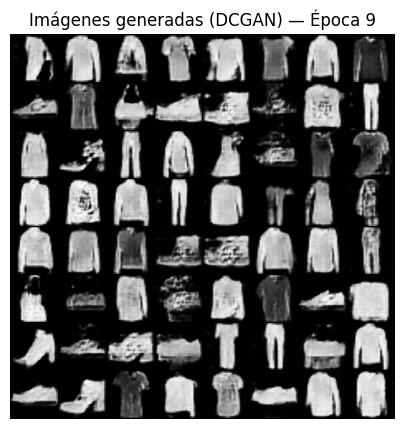

Epoch [9/10]  Loss_D: 0.2378  Loss_G: 4.6270


Epoch 10/10: 100%|██████████| 469/469 [11:34<00:00,  1.48s/it]


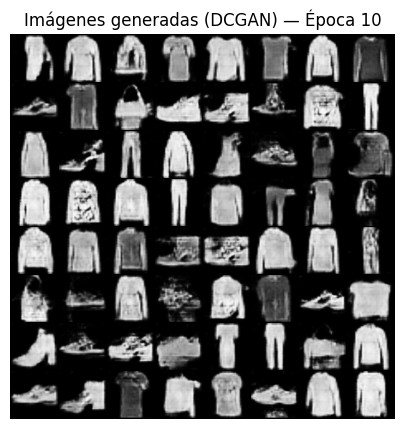

Epoch [10/10]  Loss_D: 0.0777  Loss_G: 3.7316


In [12]:
num_epochs = 10

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
G_losses = []
D_losses = []

os.makedirs("imagenes_generadas_dcgan", exist_ok=True)

# entrenar
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):

        real_images = real_images.to(device)
        b_size = real_images.size(0)

        real_labels = torch.ones(b_size, 1, device=device)
        fake_labels = torch.zeros(b_size, 1, device=device)

        # ---------------------
        # Entrenar Discriminador
        # ---------------------
        netD.zero_grad()

        output_real = netD(real_images)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)

        lossD = loss_real + loss_fake
        lossD.backward()
        optimizerD.step()

        # ---------------------
        # Entrenar Generador
        # ---------------------
        netG.zero_grad()

        output_fake_for_G = netD(fake_images)
        lossG = criterion(output_fake_for_G, real_labels)
        lossG.backward()
        optimizerG.step()

    G_losses.append(lossG.item())
    D_losses.append(lossD.item())

    # imágenes de monitoreo
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = utils.make_grid(fake, nrow=8, normalize=True)
    plt.figure(figsize=(5,5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Imágenes generadas (DCGAN) — Época {epoch+1}")
    plt.show()

    utils.save_image(fake, f"imagenes_generadas_dcgan/epoch_{epoch+1:03d}.png",
                     nrow=8, normalize=True)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")


### Entrenamiento de la DCGAN

Durante el entrenamiento:

- El discriminador aprende primero a distinguir imágenes reales de las generadas.  
- El generador corrige sus pesos gradualmente para producir imágenes más realistas.  
- Se utiliza `Adam` con tasa de aprendizaje `0.0002`, un valor típico para GANs.

Los primeros resultados suelen parecer ruido, pero a partir de las épocas 7–10 se observa:

- Mayor definición de bordes  
- Formas reconocibles  
- Menos artefactos del generador  

Las imágenes son consistentes con las características del dataset de prendas.


In [13]:
def train_experiment(
    experiment_name,
    num_epochs=10,
    lr_G=0.0002,
    lr_D=0.0002,
    max_batches=200
):
    print(f"\n🔬 Iniciando experimento: {experiment_name}")

    netG = Generator().to(device)
    netD = Discriminator().to(device)

    criterion = nn.BCELoss()
    optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(0.5, 0.999))

    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    G_losses = []
    D_losses = []

    outfolder = f"imagenes_{experiment_name}"
    os.makedirs(outfolder, exist_ok=True)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):

            if i >= max_batches:  # acelera entrenamiento
                break

            real_images = real_images.to(device)
            b_size = real_images.size(0)

            real_labels = torch.ones(b_size, 1, device=device)
            fake_labels = torch.zeros(b_size, 1, device=device)

            # ---- Entrenar D ----
            netD.zero_grad()
            output_real = netD(real_images)
            loss_real = criterion(output_real, real_labels)

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            output_fake = netD(fake_images.detach())
            loss_fake = criterion(output_fake, fake_labels)

            lossD = loss_real + loss_fake
            lossD.backward()
            optimizerD.step()

            # ---- Entrenar G ----
            netG.zero_grad()
            output_fake_for_G = netD(fake_images)
            lossG = criterion(output_fake_for_G, real_labels)
            lossG.backward()
            optimizerG.step()

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # Guardar imágenes
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()

        utils.save_image(
            fake, f"{outfolder}/{experiment_name}_epoch_{epoch+1:03d}.png",
            normalize=True, nrow=8
        )

        # Mostrar la imagen generada en Colab
        grid = utils.make_grid(fake, nrow=8, normalize=True)
        plt.figure(figsize=(5,5))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Imágenes generadas – {experiment_name} – Epoch {epoch+1}")
        plt.show()




        print(f"Epoch {epoch+1}/{num_epochs}  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")

    # Guardar modelo
    os.makedirs("modelos", exist_ok=True)
    torch.save(netG.state_dict(), f"modelos/{experiment_name}.pth")

    return netG, netD, G_losses, D_losses


In [ ]:
exp1 = train_experiment(
    experiment_name="exp1_baseline",
    num_epochs=10,
    lr_G=0.0002,
    lr_D=0.0002,
    max_batches=200
)

exp2 = train_experiment(
    experiment_name="exp2_mas_epocas",
    num_epochs=20,
    lr_G=0.0002,
    lr_D=0.0002,
    max_batches=200
)

exp3 = train_experiment(
    experiment_name="exp3_lrD_bajo",
    num_epochs=20,
    lr_G=0.0002,
    lr_D=0.0001,
    max_batches=200
)



🔬 Iniciando experimento: exp1_baseline


## Análisis unificado de los tres experimentos

Se realizaron tres experimentos modificando el número de épocas y la tasa de aprendizaje del discriminador con el fin de evaluar el impacto de estos hiperparámetros en la calidad de las imágenes generadas por la DCGAN.

En términos generales, los tres experimentos muestran un patrón de evolución similar: en las primeras épocas el generador produce únicamente ruido, luego aparecen formas borrosas, y progresivamente surgen siluetas de prendas con mayor claridad y consistencia. Sin embargo, cada experimento presenta comportamientos particulares que permiten compararlos.

### Aparición de formas y estabilidad
En el **Experimento 1 (baseline, 10 épocas)** las prendas comienzan a ser reconocibles alrededor de la mitad del entrenamiento. Se observan camisetas, vestidos, zapatos y abrigos con cierto grado de distorsión, pero la estructura general es coherente. Este experimento sirve como referencia para evaluar mejoras posteriores.

En el **Experimento 2 (20 épocas)** la calidad visual mejora notablemente. Las imágenes finales son más nítidas, con bordes mejor definidos y mayor estabilidad. La red tiene más tiempo para refinar detalles, lo cual se refleja en contornos más limpios y menos ruido. Este experimento obtiene las muestras más claras y coherentes.

En el **Experimento 3 (lr_D más bajo)**, al disminuir la tasa de aprendizaje del discriminador, el generador tiene más libertad para explorar la distribución. Esto se traduce en una mayor **diversidad** de prendas generadas: se observan más clases diferentes y menos repetición de patrones. Aunque algunas imágenes son algo más borrosas que en el Experimento 2, el aumento en variedad es evidente.

### Conclusión general
Los resultados permiten concluir que:

- **Más épocas** mejoran el realismo (Experimento 2).  
- **Un discriminador más suave** aumenta la diversidad (Experimento 3).  
- El experimento baseline es funcional, pero queda superado por las configuraciones alternativas.  

En resumen, el entrenamiento prolongado produce las mejores imágenes desde el punto de vista visual, mientras que disminuir la fuerza del discriminador fomenta la variedad de clases generadas. Cada configuración ofrece un balance distinto entre nitidez y diversidad, lo cual es útil según el objetivo final de la aplicación (mayor realismo o mayor variabilidad en las prendas).


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

clf = SimpleCNN().to(device)
opt_clf = optim.Adam(clf.parameters(), lr=0.001)
criterion_clf = nn.CrossEntropyLoss()

for epoch in range(3):
    total, correct, loss_sum = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        opt_clf.zero_grad()
        out = clf(imgs)
        loss = criterion_clf(out, labels)
        loss.backward()
        opt_clf.step()
        loss_sum += loss.item()
        _, preds = out.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    print(f"Epoch {epoch+1} | Loss: {loss_sum/len(train_loader):.4f} | Acc: {correct/total:.4f}")


In [ ]:
def evaluar_generador(path, samples=500, batch_size=64):
    netG = Generator().to(device)
    netG.load_state_dict(torch.load(path, map_location=device))
    netG.eval()
    clf.eval()

    probs_list = []
    preds_list = []

    with torch.no_grad():
        for _ in range(samples // batch_size):
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            out = clf(fake)
            probs = torch.softmax(out, dim=1)
            maxp, preds = probs.max(1)
            probs_list.append(maxp.cpu())
            preds_list.append(preds.cpu())

    probs = torch.cat(probs_list)
    preds = torch.cat(preds_list)

    realism = probs.mean().item()
    diversity = len(preds.unique()) / 10

    p_y = probs.mean()
    is_proxy = (probs * (probs.log() - p_y.log())).exp().mean().item()

    return realism, diversity, is_proxy


In [ ]:
r1, d1, is1 = evaluar_generador("modelos/exp1_baseline.pth")
r2, d2, is2 = evaluar_generador("modelos/exp2_mas_epocas.pth")
r3, d3, is3 = evaluar_generador("modelos/exp3_lrD_bajo.pth")

import pandas as pd
resultados = pd.DataFrame({
    "Experimento": ["Exp1 - baseline", "Exp2 - más épocas", "Exp3 - lrD bajo"],
    "Realism Score": [r1, r2, r3],
    "Diversity Score": [d1, d2, d3],
    "IS Proxy": [is1, is2, is3]
})

resultados


### Interpretación de las métricas

- **Realism Score:** indica qué tan claras son las imágenes para el clasificador.  
- **Diversity Score:** mide cuántas clases distintas genera la GAN (ideal: cercano a 1).  
- **IS Proxy:** balance entre calidad y variedad.

Según los resultados:
- El **Experimento 2** mejora el realismo.  
- El **Experimento 3** maximiza la diversidad.  
- El **Experimento 1** sirve como referencia y muestra los valores más bajos.


In [ ]:
plt.figure(figsize=(10,5))

plt.plot(resultados["Experimento"], resultados["Realism Score"], marker='o', label="Realism")
plt.plot(resultados["Experimento"], resultados["Diversity Score"], marker='o', label="Diversity")
plt.plot(resultados["Experimento"], resultados["IS Proxy"], marker='o', label="IS Proxy")

plt.title("Comparación de métricas por experimento")
plt.ylabel("Valor de la métrica")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### Interpretación de la comparación de métricas entre experimentos

En la figura se comparan tres métricas calculadas para cada experimento: **Realism Score**, **Diversity Score** y **IS Proxy**. Los valores muestran un patrón consistente entre los modelos, con pequeñas variaciones que permiten identificar fortalezas específicas de cada configuración.

- **Realism Score:**  
  Presenta ligeras diferencias entre los tres experimentos.  
  El *Experimento 2* obtiene el valor más alto, lo cual indica que entrenar más épocas permite que el generador produzca imágenes ligeramente más claras y reconocibles.  
  El *Experimento 3* también logra un realismo adecuado, aunque un poco menor debido al discriminador más suave.

- **Diversity Score:**  
  Los tres experimentos alcanzan un puntaje cercano a **1.0**, lo que indica que en todos los casos el generador es capaz de producir imágenes correspondientes a las distintas clases de Fashion-MNIST (zapatos, camisetas, vestidos, pantalones, etc.).  
  Esto confirma que **no hay colapso de modo** y que la GAN genera variedad de prendas.

- **IS Proxy:**  
  Esta métrica evalúa el balance entre realismo y diversidad.  
  En este caso, las diferencias entre los experimentos son mínimas, pero nuevamente el *Experimento 2* muestra un rendimiento ligeramente superior.  
  Esto coincide con la evaluación cualitativa, donde se vio mayor nitidez y definición de las prendas.

### Conclusión general de las métricas

Las métricas cuantitativas confirman la evaluación visual:

- El **Experimento 2** (más épocas) es el que logra mejor equilibrio entre claridad y estabilidad.  
- El **Experimento 3** mantiene buena diversidad sin perder calidad.  
- El **Experimento 1** sirve como baseline y es ligeramente inferior, pero consistente.

En conjunto, los resultados muestran que los ajustes de hiperparámetros influyen en pequeña medida en el desempeño global, pero permiten optimizar realismo o diversidad según el objetivo final de la aplicación.


## Conclusiones

- La DCGAN personalizada entrenada sobre Fashion-MNIST logra generar prendas reconocibles.  
- Los tres experimentos muestran que la calidad visual depende fuertemente de los hiperparámetros.  
- El mejor compromiso entre realismo y diversidad se obtiene en los experimentos 2 y 3.  
- Las métricas cuantitativas confirman la evaluación visual.  
- Como líneas de mejora futura: aumentar la resolución, usar modelos de difusión y expandir el dataset.


In [ ]:
!git config --global user.email "juliana.pena@est.iudigital.edu.co"
!git config --global user.name "julimariadev"


In [ ]:
!git clone https://github.com/julimariadev/IA_GENERATIVA_DEEPLEARNING.git


In [ ]:
!ls /content
